In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nasa-cmaps


#Data Preprocessing

In [7]:
import pandas as pd
import numpy as np

# Load the dataset
train_data = pd.read_csv('train_FD001.txt', sep=" ", header=None)
test_data = pd.read_csv('test_FD001.txt', sep=" ", header=None)
rul_data = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)

# Drop unnecessary columns (last two columns are NaNs)
train_data.drop(columns=[26, 27], inplace=True)
test_data.drop(columns=[26, 27], inplace=True)

# Add column names
columns = ['engine_id', 'cycle'] + [f'sensor_{i}' for i in range(1, 22)] + ['op_setting_1', 'op_setting_2', 'op_setting_3']
train_data.columns = columns
test_data.columns = columns

# Add RUL (Remaining Useful Life) to the training data
def add_rul(df):
    max_cycle = df.groupby('engine_id')['cycle'].max().reset_index()
    max_cycle.columns = ['engine_id', 'max_cycle']
    df = df.merge(max_cycle, on='engine_id', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df.drop(columns=['max_cycle'], inplace=True)
    return df

train_data = add_rul(train_data)

# Check the data
print(train_data.head())

   engine_id  cycle  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0          1      1   -0.0007   -0.0004     100.0    518.67    641.82   
1          1      2    0.0019   -0.0003     100.0    518.67    642.15   
2          1      3   -0.0043    0.0003     100.0    518.67    642.35   
3          1      4    0.0007    0.0000     100.0    518.67    642.35   
4          1      5   -0.0019   -0.0002     100.0    518.67    642.37   

   sensor_6  sensor_7  sensor_8  ...  sensor_16  sensor_17  sensor_18  \
0   1589.70   1400.60     14.62  ...    2388.02    8138.62     8.4195   
1   1591.82   1403.14     14.62  ...    2388.07    8131.49     8.4318   
2   1587.99   1404.20     14.62  ...    2388.03    8133.23     8.4178   
3   1582.79   1401.87     14.62  ...    2388.08    8133.83     8.3682   
4   1582.85   1406.22     14.62  ...    2388.04    8133.80     8.4294   

   sensor_19  sensor_20  sensor_21  op_setting_1  op_setting_2  op_setting_3  \
0       0.03        392       2388        

#Exploratory Data Analysis (EDA)

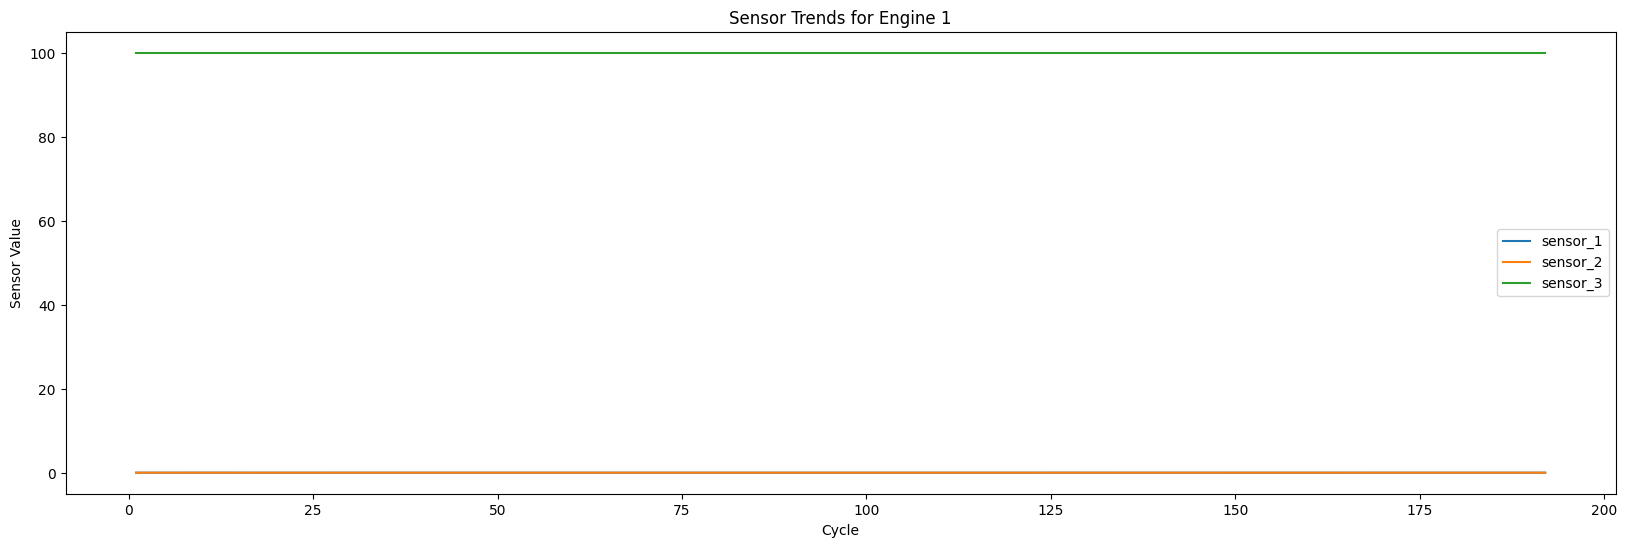

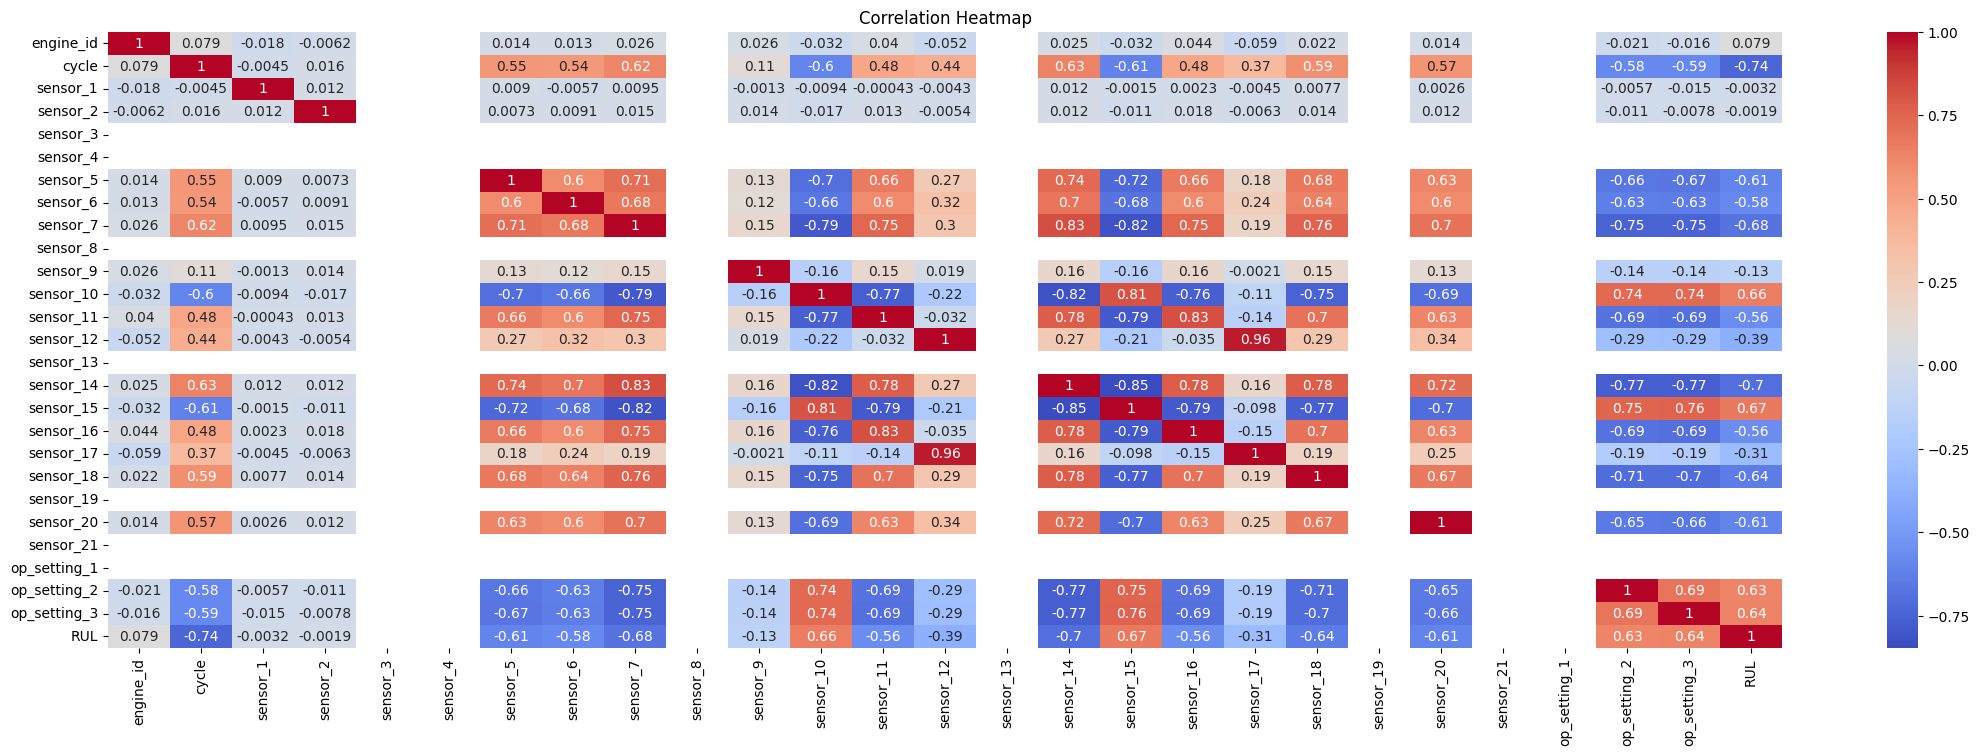

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sensor trends for a single engine
engine_id = 1
engine_data = train_data[train_data['engine_id'] == engine_id]

plt.figure(figsize=(20, 6))
for sensor in ['sensor_1', 'sensor_2', 'sensor_3']:
    plt.plot(engine_data['cycle'], engine_data[sensor], label=sensor)
plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.title(f'Sensor Trends for Engine {engine_id}')
plt.legend()
plt.show()

# Correlation heatmap
plt.figure(figsize=(27, 8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
X = train_data.drop(columns=['engine_id', 'cycle', 'RUL'])
y = train_data['RUL']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

RMSE: 41.5214287563132
R2 Score: 0.6226512682402188


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the features for KMeans
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
# Choose the number of clusters (you might need to experiment with this)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Add n_init
train_data['cluster'] = kmeans.fit_predict(X_scaled)

# You can now use the 'cluster' column for further analysis or as a feature
print(train_data.head())

   engine_id  cycle  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0          1      1   -0.0007   -0.0004     100.0    518.67    641.82   
1          1      2    0.0019   -0.0003     100.0    518.67    642.15   
2          1      3   -0.0043    0.0003     100.0    518.67    642.35   
3          1      4    0.0007    0.0000     100.0    518.67    642.35   
4          1      5   -0.0019   -0.0002     100.0    518.67    642.37   

   sensor_6  sensor_7  sensor_8  ...  sensor_17  sensor_18  sensor_19  \
0   1589.70   1400.60     14.62  ...    8138.62     8.4195       0.03   
1   1591.82   1403.14     14.62  ...    8131.49     8.4318       0.03   
2   1587.99   1404.20     14.62  ...    8133.23     8.4178       0.03   
3   1582.79   1401.87     14.62  ...    8133.83     8.3682       0.03   
4   1582.85   1406.22     14.62  ...    8133.80     8.4294       0.03   

   sensor_20  sensor_21  op_setting_1  op_setting_2  op_setting_3  RUL  \
0        392       2388         100.0         39

#Data Export

In [12]:
# Add predictions to the test data
test_data['RUL_pred'] = model.predict(test_data.drop(columns=['engine_id', 'cycle']))

# Export to CSV
test_data.to_csv('predictive_maintenance_results.xlsx', index=False)